In [1]:
import pandas as pd
import numpy as np
import random
from scipy import stats
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return [v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)
            for v in vec]

def pct_error(orig, priv):
    return float(np.abs(orig - priv)/orig * 100.0)

compas = pd.read_csv('cox-violent-parsed.csv')
adult = pd.read_csv('adult_with_pii.csv')

# Columns to drop: ID, v_screening_date, in_custody, out_custody, priors_count.1, start, end, event
# This was used to remove duplicate rows that contained the same person with the same crime so that they were not counted multiple times.
compas = compas.drop(['id', 'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1', 'start', 'end', 'event'], axis=1)
compas = compas.drop_duplicates()

In [2]:
# compas # id column only increments up to 11001 without the fix (technically the 11000th row, starting at 0)

# Alternative DP Definitions
The cells below compare the accuracy results of the following differentially private algorithms across the adult and COMPAS datasets.

## Renyi-Differential Privacy, Zero-Concentrated Differential Privacy, and Epsilon Delta Differential Privacy

In [3]:
# Renyi-Differential Privacy Algorithm
# credit to Joe Near for python implementation
def gaussian_mech_RDP(val, sensitivity, alpha, epsilon):
    sigma = np.sqrt((sensitivity**2 * alpha) / (2 * epsilon))
    return val + np.random.normal(loc=0, scale=sigma)

# Epsilon-Delta Algorithm
def gaussian_mech_EDP(val, sensitivity, epsilon, delta):
    return val + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

# zero-Concentrated Algorithm
def gaussian_mech_zCDP(val, sensitivity, rho):
    sigma = np.sqrt((sensitivity**2 / (2*rho)))
    return val + np.random.normal(loc=0, scale=sigma)

# RDP Vector Implementation
def gaussian_mech_vec_RDP(vec, sensitivity, alpha, epsilon):
    return [gaussian_mech_RDP(v, sensitivity=sensitivity, alpha=alpha, epsilon=epsilon/len(vec)) for v in vec]

# RDP Epsilon -> Epsilon Delta Epsilon
def rdp_convert(alpha, epsilon_bar, delta):
    return epsilon_bar + np.log(1/delta) / (alpha-1)

# zCDP Convert -> Epsilon Delta Epsilon
def zcdp_convert(rho, delta):
    return rho + 2 * np.sqrt(rho * np.log(1/delta))

### Summation

In [4]:
def rdp_sum(dataset, sensitivity, alpha, epsilon):
    clipped_data = dataset.clip(upper=sensitivity)
    # run the query and return the result
    return gaussian_mech_RDP(sum(clipped_data), sensitivity=sensitivity, alpha=alpha, epsilon=epsilon)

def edp_sum(dataset, sensitivity, epsilon, delta):
    clipped_data = dataset.clip(upper=sensitivity)
    # run the query and return the result
    return gaussian_mech_EDP(sum(clipped_data), sensitivity=sensitivity, epsilon=epsilon, delta=delta)

def zcdp_sum(dataset, sensitivity, rho):
    clipped_data = dataset.clip(upper=sensitivity)
    # run the query and return the result
    return gaussian_mech_zCDP(sum(clipped_data), sensitivity=sensitivity, rho=rho)

In [5]:
epsilon = .01
alpha = 5
delta = 1e-5
rho = .0001
b_adult = 100
b_compas = 100

# Run Tests Here
# Adult Dataset
adult_real_results = adult['Age'].sum()
adult_edp_results = [edp_sum(adult['Age'],sensitivity=b_adult,epsilon=epsilon,delta=delta) for _ in range(100)]
adult_rdp_results = [rdp_sum(adult['Age'],sensitivity=b_adult,alpha=alpha,epsilon=epsilon) for _ in range(100)]
adult_zcdp_results = [zcdp_sum(adult['Age'],sensitivity=b_adult,rho=rho) for _ in range(100)]

# COMPAS Dataset
compas_real_results = compas['age'].sum()
compas_edp_results = [edp_sum(compas['age'],sensitivity=b_compas,epsilon=epsilon,delta=delta) for _ in range(100)]
compas_rdp_results = [rdp_sum(compas['age'],sensitivity=b_compas,alpha=alpha,epsilon=epsilon) for _ in range(100)]
compas_zcdp_results = [zcdp_sum(compas['age'],sensitivity=b_compas,rho=rho) for _ in range(100)]


# Error Results
adult_edp_error = np.sum([pct_error(adult_real_results, result) for result in adult_edp_results])/100
adult_rdp_error = np.sum([pct_error(adult_real_results, result) for result in adult_rdp_results])/100
adult_zcdp_error = np.sum([pct_error(adult_real_results, result) for result in adult_zcdp_results])/100
compas_edp_error = np.sum([pct_error(compas_real_results, result) for result in compas_edp_results])/100
compas_rdp_error = np.sum([pct_error(compas_real_results, result) for result in compas_rdp_results])/100
compas_zcdp_error = np.sum([pct_error(compas_real_results, result) for result in compas_zcdp_results])/100

print("Adult Dataset:")
print("Adult Epsilon-Delta Error:",adult_edp_error)
print("Adult Renyi Error:",adult_rdp_error)
print("Adult Zero-Concentrated Error:",adult_zcdp_error)
print("Compas Dataset:")
print("COMPAS Epsilon-Delta Error:",compas_edp_error)
print("COMPAS Renyi Error:",compas_rdp_error)
print("COMPAS Zero-Concentrated Error:",compas_zcdp_error)

Adult Dataset:
Adult Epsilon-Delta Error: 2.623125560399481
Adult Renyi Error: 0.09509796369400822
Adult Zero-Concentrated Error: 0.4080304066324978
Compas Dataset:
COMPAS Epsilon-Delta Error: 9.516851192867987
COMPAS Renyi Error: 0.34326390681308006
COMPAS Zero-Concentrated Error: 1.3488991993369985


### Count

In [6]:
def gaussian_mech_RDP(val, sensitivity, alpha, epsilon):
    sigma = np.sqrt((sensitivity**2 * alpha) / (2 * epsilon))
    return val + np.random.normal(loc=0, scale=sigma)
    
def rdp_count(dataset, sensitivity, alpha, epsilon):
    return gaussian_mech_RDP(dataset, sensitivity=sensitivity, alpha=alpha, epsilon=epsilon)

def edp_count(dataset, sensitivity, epsilon, delta):
    return gaussian_mech_EDP(dataset, sensitivity=sensitivity, epsilon=epsilon, delta=delta)

def zcdp_count(dataset, sensitivity, rho):
    return gaussian_mech_zCDP(dataset, sensitivity=sensitivity, rho=rho)

In [7]:
epsilon = .01
alpha = 5
delta = 1e-5
rho = .0001
b_adult = 1
b_compas = 1

# Run Tests Here
# Adult Dataset
adult_real_results = int(adult['Age'].count())
adult_rdp_results = [rdp_count(adult_real_results,sensitivity=b_adult,alpha=alpha,epsilon=epsilon) for _ in range(100)]
adult_edp_results = [edp_count(adult_real_results,sensitivity=b_adult,epsilon=epsilon,delta=delta) for _ in range(100)]
adult_zcdp_results = [zcdp_count(adult_real_results,sensitivity=b_adult,rho=rho) for _ in range(100)]

adult_rdp_error = np.sum([pct_error(adult_real_results, result) for result in adult_rdp_results])/100
adult_edp_error = np.sum([pct_error(adult_real_results, result) for result in adult_edp_results])/100
adult_zcdp_error = np.sum([pct_error(adult_real_results, result) for result in adult_zcdp_results])/100

# COMPAS Dataset
compas_real_results = int(compas['age'].count())
compas_edp_results = [edp_count(compas_real_results,sensitivity=b_compas,epsilon=epsilon,delta=delta) for _ in range(100)]
compas_rdp_results = [rdp_count(compas_real_results,sensitivity=b_compas,alpha=alpha,epsilon=epsilon) for _ in range(100)]
compas_zcdp_results = [zcdp_count(compas_real_results,sensitivity=b_compas,rho=rho) for _ in range(100)]

compas_edp_error = np.sum([pct_error(compas_real_results, result) for result in compas_edp_results])/100
compas_rdp_error = np.sum([pct_error(compas_real_results, result) for result in compas_rdp_results])/100
compas_zcdp_error = np.sum([pct_error(compas_real_results, result) for result in compas_zcdp_results])/100

print("Adult Dataset:")
print("Adult Epsilon-Delta Error:",adult_edp_error)
print("Adult Renyi Error:",adult_rdp_error)
print("Adult Zero-Concentrated Error:",adult_zcdp_error)
print("Compas Dataset:")
print("COMPAS Epsilon-Delta Error:",compas_edp_error)
print("COMPAS Renyi Error:",compas_rdp_error)
print("COMPAS Zero-Concentrated Error:",compas_zcdp_error)

Adult Dataset:
Adult Epsilon-Delta Error: 1.195666786986351
Adult Renyi Error: 0.0371000365032197
Adult Zero-Concentrated Error: 0.16602806202679365
Compas Dataset:
COMPAS Epsilon-Delta Error: 3.739499914976644
COMPAS Renyi Error: 0.11759175819204419
COMPAS Zero-Concentrated Error: 0.530295517584505


### Average

In [8]:
def rdp_avg(dataset, sensitivity, alpha, epsilon):
    clipped_data = dataset.clip(upper=sensitivity)
    # add noise to sum query
    noisy_sum = gaussian_mech_RDP(sum(clipped_data), sensitivity=sensitivity, alpha=alpha, epsilon=epsilon/2)
    # add noise to count query
    noisy_count = gaussian_mech_RDP(len(clipped_data),sensitivity=1,alpha=alpha,epsilon=epsilon/2)
    return noisy_sum/noisy_count

def edp_avg(dataset, sensitivity, epsilon, delta):
    clipped_data = dataset.clip(upper=sensitivity)
    # add noise to sum query
    noisy_sum = gaussian_mech_EDP(sum(clipped_data), sensitivity=sensitivity, epsilon=epsilon/2, delta=delta)
    # add noise to count query
    noisy_count = gaussian_mech_EDP(len(clipped_data),sensitivity=1,epsilon=epsilon/2,delta=delta)
    return noisy_sum/noisy_count

def zcdp_avg(dataset, sensitivity, rho):
    clipped_data = dataset.clip(upper=sensitivity)
    # add noise to sum query
    noisy_sum = gaussian_mech_zCDP(sum(clipped_data), sensitivity=sensitivity, rho=rho/2)
    # add noise to count query
    noisy_count = gaussian_mech_zCDP(len(clipped_data),sensitivity=1,rho=rho/2)
    return noisy_sum/noisy_count

In [9]:
epsilon = .01
alpha = 5
delta = 1e-5
rho = .0001
b_adult = 100
b_compas = 100

# Run Tests Here
# Adult Dataset
adult_real_results = adult['Age'].sum() / adult['Age'].count()
adult_edp_results = [edp_avg(adult['Age'],sensitivity=b_adult,epsilon=epsilon,delta=delta) for _ in range(100)]
adult_rdp_results = [rdp_avg(adult['Age'],sensitivity=b_adult,alpha=alpha,epsilon=epsilon) for _ in range(100)]
adult_zcdp_results = [zcdp_avg(adult['Age'],sensitivity=b_adult,rho=rho) for _ in range(100)]

# COMPAS Dataset
compas_real_results = compas['age'].sum() / compas['age'].count()
compas_edp_results = [edp_avg(compas['age'],sensitivity=b_compas,epsilon=epsilon,delta=delta) for _ in range(100)]
compas_rdp_results = [rdp_avg(compas['age'],sensitivity=b_compas,alpha=alpha,epsilon=epsilon) for _ in range(100)]
compas_zcdp_results = [zcdp_avg(compas['age'],sensitivity=b_compas,rho=rho) for _ in range(100)]


# Error Results
adult_edp_error = np.sum([pct_error(adult_real_results, result) for result in adult_edp_results])/100
adult_rdp_error = np.sum([pct_error(adult_real_results, result) for result in adult_rdp_results])/100
adult_zcdp_error = np.sum([pct_error(adult_real_results, result) for result in adult_zcdp_results])/100
compas_edp_error = np.sum([pct_error(compas_real_results, result) for result in compas_edp_results])/100
compas_rdp_error = np.sum([pct_error(compas_real_results, result) for result in compas_rdp_results])/100
compas_zcdp_error = np.sum([pct_error(compas_real_results, result) for result in compas_zcdp_results])/100

print("Adult Dataset:")
print("Adult Epsilon-Delta Error:",adult_edp_error)
print("Adult Renyi Error:",adult_rdp_error)
print("Adult Zero-Concentrated Error:",adult_zcdp_error)
print("Compas Dataset:")
print("COMPAS Epsilon-Delta Error:",compas_edp_error)
print("COMPAS Renyi Error:",compas_rdp_error)
print("COMPAS Zero-Concentrated Error:",compas_zcdp_error)

Adult Dataset:
Adult Epsilon-Delta Error: 6.504984113493549
Adult Renyi Error: 0.17121612004023923
Adult Zero-Concentrated Error: 0.6508435928528555
Compas Dataset:
COMPAS Epsilon-Delta Error: 20.31823404384493
COMPAS Renyi Error: 0.5257821387071013
COMPAS Zero-Concentrated Error: 2.0234813671525855


In [10]:
# decile_score includes ALL of the recorded risk scores
# v_decile_score is just violent risk scores
# plt.hist(compas['decile_score'], bins=10)

# Synthetic Representations

Creating a synthetic representation used to create synthetic data for testing

In [11]:
# Getting a synthetic representation of the overall decile_score data
def noisy_score_hist(dataset, sensitivity, epsilon):
    hist = dataset.value_counts()
    # Parallel composition applies because it is a histogram
    return hist.apply(lambda x: laplace_mech(x, sensitivity, epsilon))

(array([  14., 2401., 1472., 1179., 1132.,  972.,  930.,  843.,  750.,
        1308.]),
 array([-1. ,  0.1,  1.2,  2.3,  3.4,  4.5,  5.6,  6.7,  7.8,  8.9, 10. ]),
 <BarContainer object of 10 artists>)

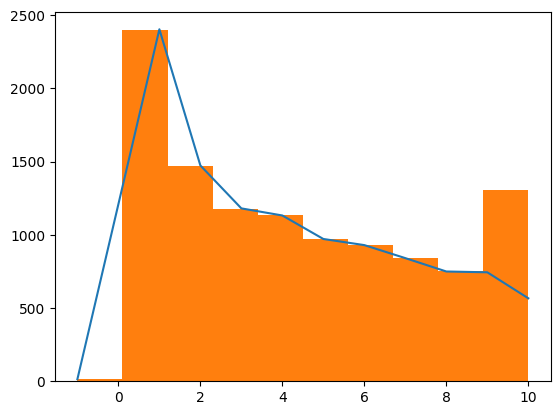

In [12]:
# Line representing synthetic rep.
plt.plot(noisy_score_hist(compas['decile_score'], 1, 1.0).sort_index());
# Actual data
plt.hist(compas['decile_score'], bins=10)

In [13]:
# Create a one-way marginal based on any column in the compas dataset
def dp_one_way_marginal(dataset, col, sensitivity, epsilon):
    hist = dataset[col].value_counts()
    hist = hist.apply(lambda x: laplace_mech(x, sensitivity, epsilon))
    
    syn_rep = hist
    syn_rep_nonzero = syn_rep.clip(lower=0)
    syn_normalized = syn_rep_nonzero / syn_rep_nonzero.sum()
    return syn_normalized #.to_frame(name='probability').reset_index()

In [14]:
# Set sensitivity = 1 because people can only have one row in our dataset after pre-processing
dp_one_way_marginal(compas, 'decile_score', 1, 1.0).to_frame().reset_index()

,decile_score,count
0,1,0.218403
1,2,0.133787
2,3,0.107205
3,4,0.102875
4,5,0.088238
5,6,0.084568
6,7,0.076510
7,8,0.068124
8,9,0.067567
9,10,0.051498


In [15]:
# Create synthetic data 
def gen_samples(n, marginal):
    return marginal.sample(n=n, replace=True, weights='probability', axis=0)
    
def dp_synthetic_data(cols, n, epsilon):
    syn_data = pd.DataFrame()
    col_count = 0
    for c in cols:
        marginal = dp_one_way_marginal(compas, c, 1, epsilon/len(cols))
        marginal = marginal.to_frame(name='probability').reset_index()
        temp_df = pd.DataFrame(gen_samples(n, marginal), columns=[c]).reset_index()
        syn_data.insert(loc=col_count, column=c, value=temp_df[c].values.tolist())
        col_count += 1
    return syn_data
    
syn_data = dp_synthetic_data(['decile_score', 'v_decile_score'], len(compas), epsilon=1.0)
real_vals_decile = compas['decile_score']

In [16]:
# Find how accurate the synthetic data is to the random subset
# Use percent error
syn_decile_score_counts = syn_data['decile_score'].value_counts().to_dict()
real_decile_score_counts = real_vals_decile.value_counts().to_dict()

# syn_decile_score_counts = sorted(syn_decile_score_counts.items())
# print(dict(sorted(syn_decile_score_counts.items())))
syn_decile_score_counts = dict(sorted(syn_decile_score_counts.items()))
# print(syn_decile_score_counts[0][1])
# print(dict(sorted(real_decile_score_counts.items())))
real_decile_score_counts = dict(sorted(real_decile_score_counts.items()))

# store the difference values for each column
difference_vals = [real-syn for syn,real in zip(syn_decile_score_counts.values(),real_decile_score_counts.values())]
# print(difference_vals)

percent_err_per_col = [pct_error(real,syn) for syn,real in zip(syn_decile_score_counts.values(),real_decile_score_counts.values())]
print(pd.DataFrame(percent_err_per_col, columns={'Percent Error':1}))

    Percent Error
0        7.142857
1        0.374844
2        0.407609
3        1.441900
4        3.356890
5        1.131687
6        2.903226
7        5.693950
8        5.600000
9        0.806452
10       7.978723


In [17]:
# Create two-way marginal between race and decile score
def dp_two_marginal(dataset, col1, col2, sensitivity, epsilon):
    hist = dataset[[col1, col2]].value_counts()
    hist = hist.apply(lambda x: laplace_mech(x, sensitivity, epsilon))

    syn_rep = hist
    syn_rep_nonzero = syn_rep.clip(lower=0)
    syn_normalized = syn_rep_nonzero / syn_rep_nonzero.sum()
    syn_normalized = syn_normalized.to_frame().reset_index()
    return syn_normalized.rename(columns={'count':'probability'})

syn_rep_race = dp_two_marginal(compas, 'race', 'decile_score', 1, 1.0)

In [18]:
def gen_conditional(col, col2, m1_val, m2):
    conditioned_dist = m2[m2[col]==m1_val]
    return conditioned_dist.sample(n=1, weights='probability')[col2].iloc[0]
    
def dp_synthetic_data_two_marginal(dataset, n, epsilon):
    # Race & Decile Score 2-way
    # Generate 1-way marginal for race
    m1 = dp_one_way_marginal(dataset, 'race', 1, epsilon/2)
    m1 = m1.to_frame(name='probability').reset_index()
    
    # Generate 2-way marginal for race, decile_score
    m2 = dp_two_marginal(compas, 'race', 'decile_score', 1, epsilon/2)

    # Create race sampling
    race_sampled = m1.sample(n=n, replace=True, weights='probability')[['race']]
    
    race_decile = race_sampled
    # Generate occupations conditioned on race using gen_conditional
    race_decile['decile_score'] = [gen_conditional('race', 'decile_score', race, m2) for race in race_decile['race']]

    return race_decile
    
syn_data_race = dp_synthetic_data_two_marginal(compas, len(compas), 1.0)

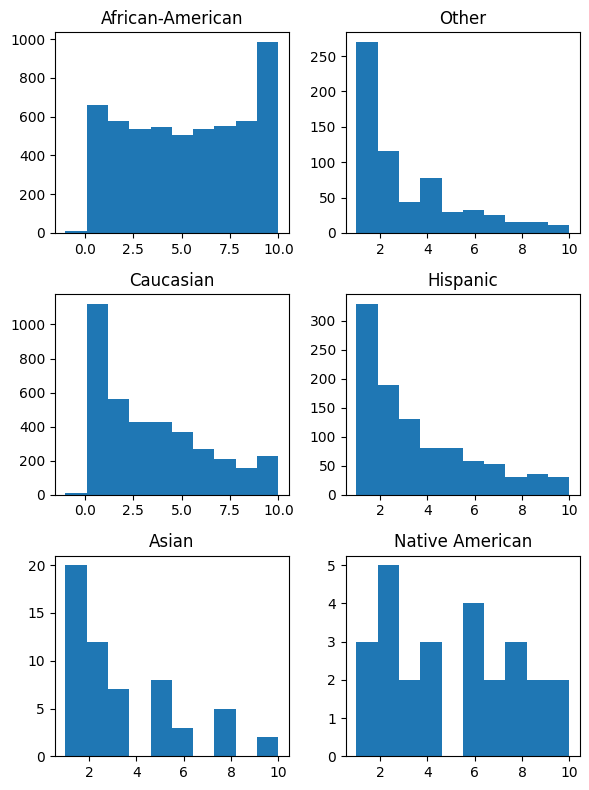

In [19]:
# Create plots for each race and their decile scores

races = syn_data_race['race'].unique()
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=3, ncols=2, figsize=(6, 8))

ax0.hist(syn_data_race[syn_data_race['race'] == races[0]]['decile_score'], 10)
# ax0.hist(compas[compas['race'] == races[0]]['decile_score'], 10, alpha=0.3)
ax0.set_title(races[0])

ax1.hist(syn_data_race[syn_data_race['race'] == races[1]]['decile_score'], 10)
# ax1.hist(compas[compas['race'] == races[1]]['decile_score'], 10, alpha=0.3)
ax1.set_title(races[1])

ax2.hist(syn_data_race[syn_data_race['race'] == races[2]]['decile_score'], 10)
# ax2.hist(compas[compas['race'] == races[2]]['decile_score'], 10, alpha=0.3)
ax2.set_title(races[2])

ax3.hist(syn_data_race[syn_data_race['race'] == races[3]]['decile_score'], 10)
# ax3.hist(compas[compas['race'] == races[3]]['decile_score'], 10, alpha=0.3)
ax3.set_title(races[3])

ax4.hist(syn_data_race[syn_data_race['race'] == races[4]]['decile_score'], 10)
# ax4.hist(compas[compas['race'] == races[4]]['decile_score'], 10, alpha=0.3)
ax4.set_title(races[4])

ax5.hist(syn_data_race[syn_data_race['race'] == races[5]]['decile_score'], 10)
# ax5.hist(compas[compas['race'] == races[5]]['decile_score'], 10, alpha=0.3)
ax5.set_title(races[5])

fig.tight_layout()
plt.show()

Focusing in on the African-American and Caucasian decile scores, we see that in our synthetic data that African-American defendants tend to have decile scores that are larger overall, while Caucasian decile scores tend to trend downwards.

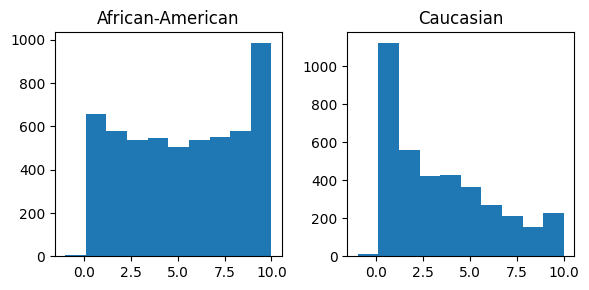

In [20]:
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

ax0.hist(syn_data_race[syn_data_race['race'] == 'African-American']['decile_score'], 10)
# ax0.hist(compas[compas['race'] == races[0]]['decile_score'], 10, alpha=0.3)
ax0.set_title('African-American')

ax1.hist(syn_data_race[syn_data_race['race'] == 'Caucasian']['decile_score'], 10)
# ax1.hist(compas[compas['race'] == races[1]]['decile_score'], 10, alpha=0.3)
ax1.set_title('Caucasian')

fig.tight_layout()
plt.show()